# Temporal Fusion Transformers(not working)

In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import ParameterGrid

from darts.timeseries import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel

## EDA(Explanatory Data Analysis)

In [194]:
df = pd.read_csv('./data/electricity.csv', parse_dates=['ds'], index_col='ds')
df[['y','Exogenous1','Exogenous2']] = df[['y','Exogenous1','Exogenous2']].astype('float32')
df

,unique_id,y,Exogenous1,Exogenous2
ds,,,,
2016-10-22 00:00:00,BE,70.000000,49593.0,57253.0
2016-10-22 01:00:00,BE,37.099998,46073.0,51887.0
2016-10-22 02:00:00,BE,37.099998,44927.0,51896.0
2016-10-22 03:00:00,BE,44.750000,44483.0,48428.0
2016-10-22 04:00:00,BE,37.099998,44338.0,46721.0
...,...,...,...,...
2018-12-23 19:00:00,PJM,32.461971,98288.0,11711.0
2018-12-23 20:00:00,PJM,32.052177,97194.0,11637.0
2018-12-23 21:00:00,PJM,27.632347,94319.0,11433.0


In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8400 entries, 2016-10-22 00:00:00 to 2018-12-23 23:00:00
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unique_id   8400 non-null   object 
 1   y           8400 non-null   float32
 2   Exogenous1  8400 non-null   float32
 3   Exogenous2  8400 non-null   float32
dtypes: float32(3), object(1)
memory usage: 229.7+ KB


In [196]:
df['unique_id'].value_counts()

unique_id
BE     1680
DE     1680
FR     1680
NP     1680
PJM    1680
Name: count, dtype: int64

In [197]:
# focus on Germany
df = df[df['unique_id'] == 'DE']

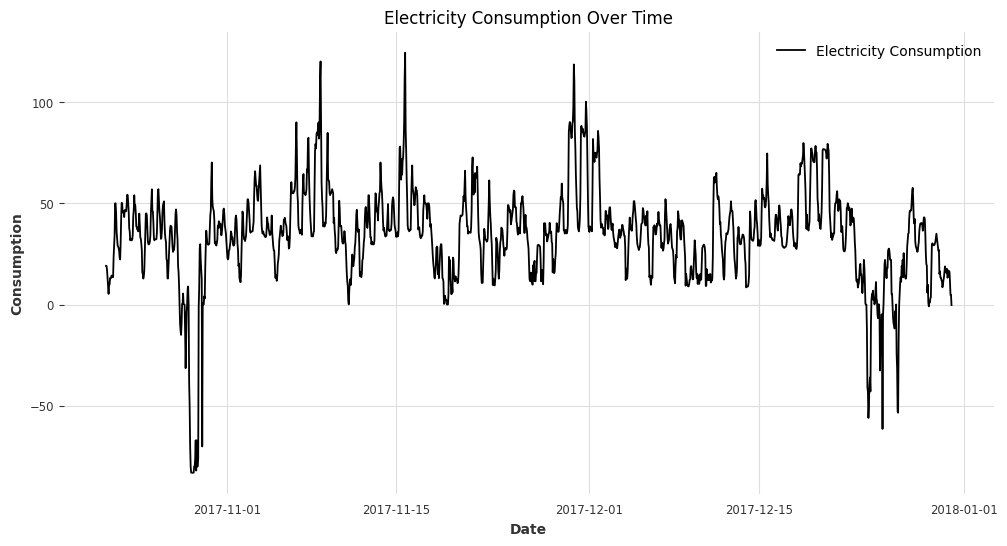

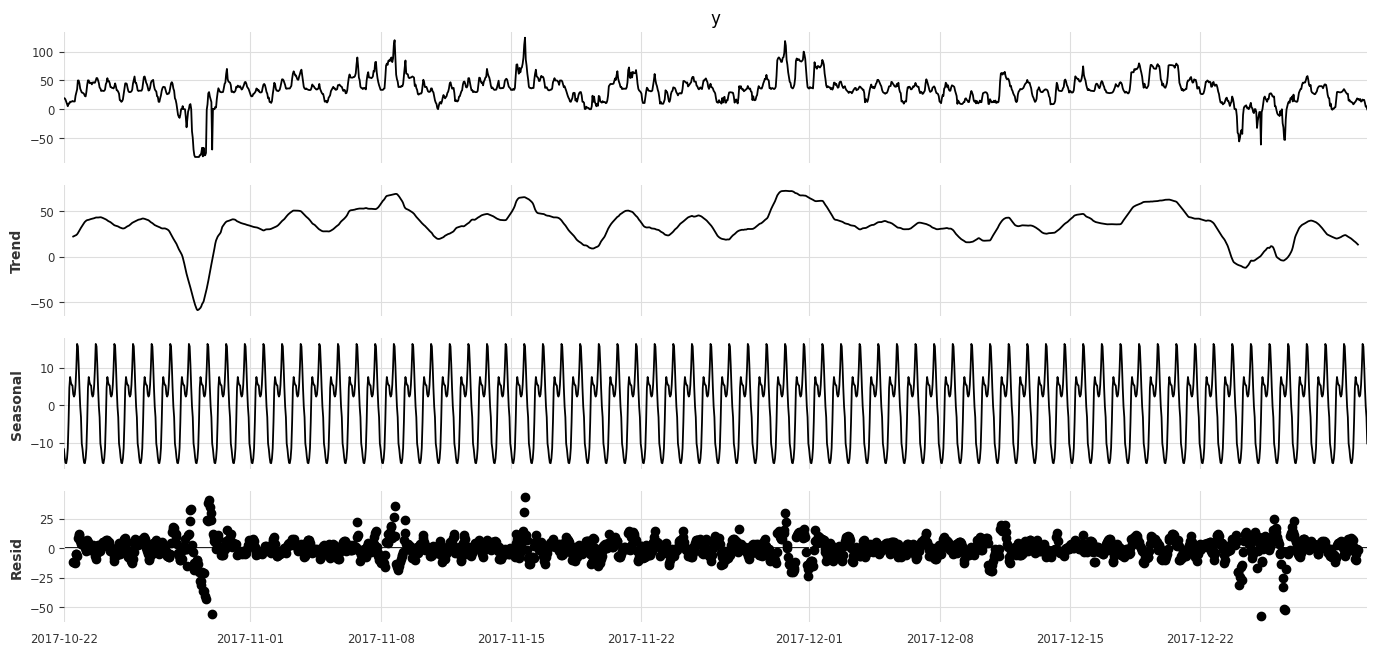

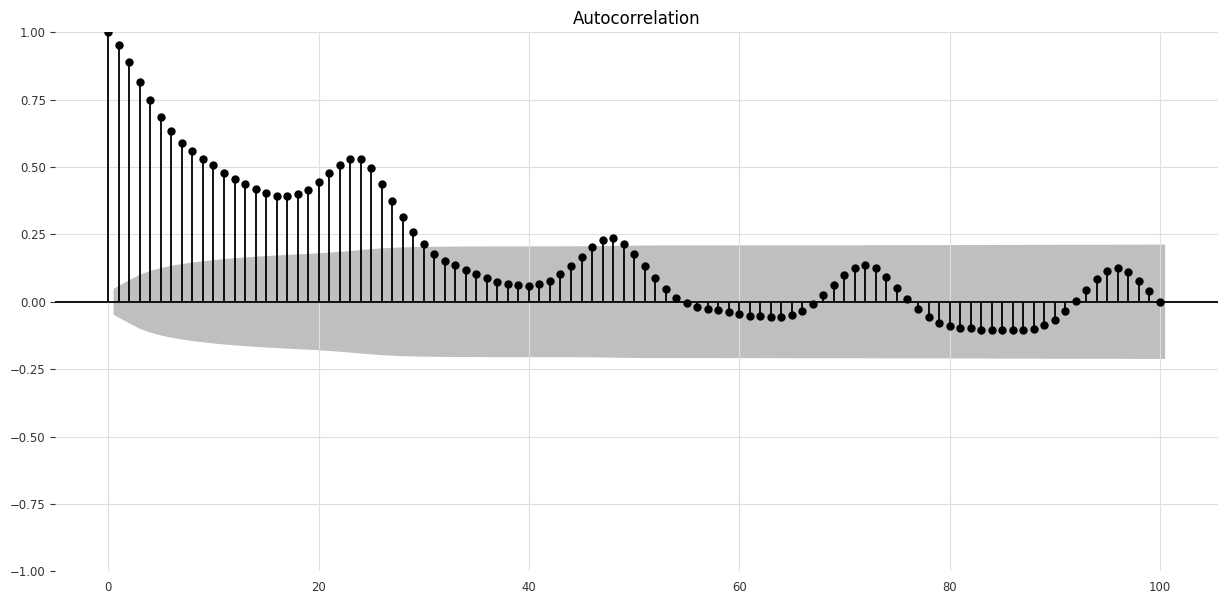

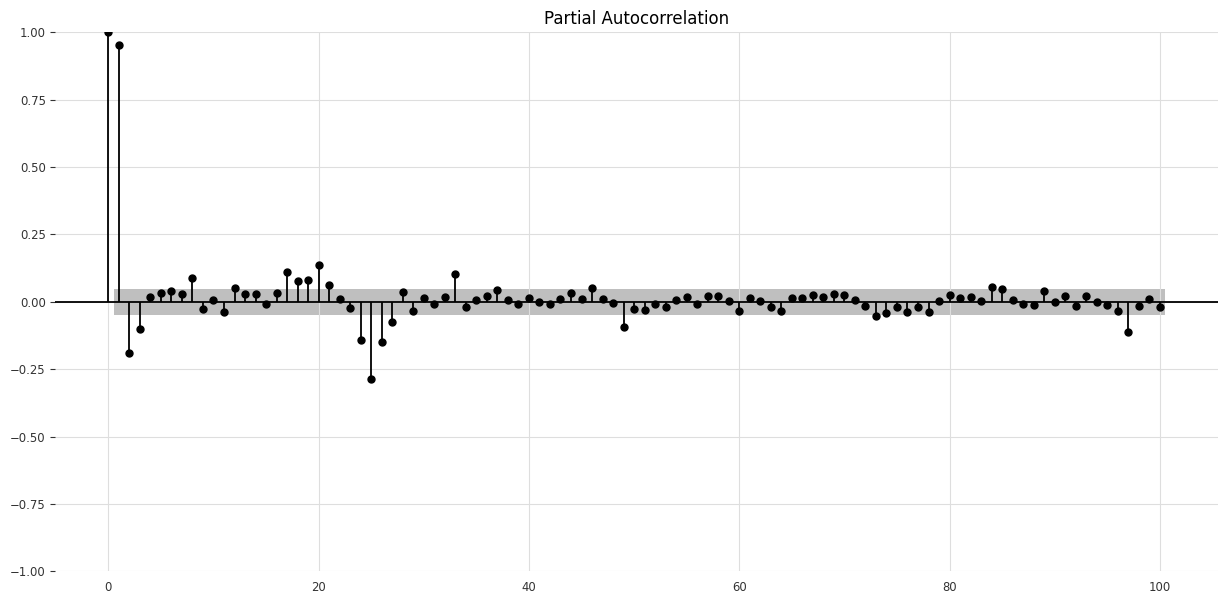

In [198]:

plt.figure(figsize=(12, 6))
plt.plot(df['y'], label='Electricity Consumption')
plt.title('Electricity Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.legend()
plt.show()

decomposition = seasonal_decompose(df['y'], model='add', period=24)
fig = decomposition.plot()
fig.set_size_inches(15, 7)
plt.show()

fig, ax = plt.subplots(figsize=(15, 7))
plot_acf(df['y'], ax=ax, lags=100)
plt.show()

fig, ax = plt.subplots(figsize=(15, 7))
plot_pacf(df['y'], ax=ax, lags=100)
plt.show()

## Preparing Data

In [199]:
df = df.asfreq('H')
y_series = TimeSeries.from_dataframe(df, value_cols='y')
y_series

/var/folders/zr/55ct9rx16hb8nk7z_w9q07900000gn/T/ipykernel_2432/794526627.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq('H')


<TimeSeries (DataArray) (ds: 1680, component: 1, sample: 1)> Size: 7kB
array([[[19.1 ]],

       [[19.03]],

       [[16.9 ]],

       ...,

       [[ 4.62]],

       [[ 4.71]],

       [[-0.27]]], dtype=float32)
Coordinates:
  * ds         (ds) datetime64[ns] 13kB 2017-10-22 ... 2017-12-30T23:00:00
  * component  (component) object 8B 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [200]:
# encode time
def encode_year(idx):
    return (idx.year - 2000) / 50
encoders = {
    'cyclic': {'future': ['hour', 'day', 'dayofweek', 'month']},
    'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'month']},
    'position': {
        'past': ['relative'],
        'future': ['relative']
    },
    # 'custom': {
    #     'past': [encode_year], 
    #     'future': [encode_year]
    # },
    'transformer': Scaler(),
    'tz': 'CET'
}

# past covariates
x_past = df.iloc[:, 2:]
past_covariates = TimeSeries.from_dataframe(x_past)
# future covariates
x_future = pd.read_csv('./data/electricity-future.csv', parse_dates=['ds'], index_col='ds')
x_future = x_future[x_future['unique_id'] == 'DE']
x_future = x_future.drop(columns=['unique_id'])
x_future.asfreq('H')
x_future[['Exogenous1', 'Exogenous2']] = x_future[['Exogenous1', 'Exogenous2']].astype('float32')
x = pd.concat([x_past, x_future])
future_covariates = TimeSeries.from_dataframe(x)

# Scaling
scaler_for_y = Scaler()
y_transformed = scaler_for_y.fit_transform(y_series)
scaler_for_covariates = Scaler()
past_covariates_transformed = scaler_for_covariates.fit_transform(past_covariates)
future_covariates_transformed = scaler_for_covariates.fit_transform(future_covariates)

/var/folders/zr/55ct9rx16hb8nk7z_w9q07900000gn/T/ipykernel_2432/2232898118.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  x_future.asfreq('H')


# TFT model

In [211]:
forecasting_horizon = 24
from darts.utils.likelihood_models import QuantileRegression
quantiles = [0.01, 0.1, 0.5, 0.9, 0.99]
model = TFTModel(
    input_chunk_length=96,  # Number of time steps in the input sequence
    output_chunk_length=forecasting_horizon,  # Number of time steps to predict
    hidden_size=16,  # Number of hidden units in the model
    lstm_layers=1,  # Number of LSTM layers
    num_attention_heads=4,  # Number of attention heads in the attention mechanism
    dropout=0.1,  # Dropout rate to prevent overfitting
    batch_size=64,  # Batch size for training
    n_epochs=10,  # Number of epochs for training
    # likelihood="quantile",
    likelihood=QuantileRegression(quantiles=quantiles),
    random_state=42,
    # optimizer_kwargs={'lr': 0.003},  # Learning rate for the optimizer
    # add_encoders=encoders,  # Encoders configuration for the model
    # use_static_covariates=True, 
    pl_trainer_kwargs={'accelerator': 'gpu', "devices": -1,'gradient_clip_val': 1.0},
)
model.fit(
    y_transformed, 
    past_covariates = past_covariates_transformed, 
    future_covariates = future_covariates_transformed, 
    )

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 3.0 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.2 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 1.1 K  | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw

Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

AttributeError: 'str' object has no attribute 'num_parameters'

In [ ]:
cv = model.historical_forecasts(
    series=y_transformed,
    past_covariates=past_covariates_transformed,
    future_covariates=future_covariates_transformed,
    forecast_horizon=forecasting_horizon,  # Number of time steps to forecast
    start=df.shape[0] - 10 * forecasting_horizon,  # Start point for the rolling forecast
    retrain=True,  # Whether to retrain the model at each step
    stride=forecasting_horizon,  # Number of time steps to move forward for each forecast
    last_points_only=False,  # Whether to only return the last points of the forecast
)

<TimeSeries (DataArray) (ds: 24, component: 1, sample: 1)> Size: 96B
array([[[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

...

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]]], dtype=float32)
Coordinates:
  * ds         (ds) datetime64[ns] 192B 2017-12-30 ... 2017-12-30T23:00:00
  * component  (component) object 8B 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
The CV error is nan


/Users/kin/.pyenv/versions/3.9.10/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kin/.pyenv/versions/3.9.10/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


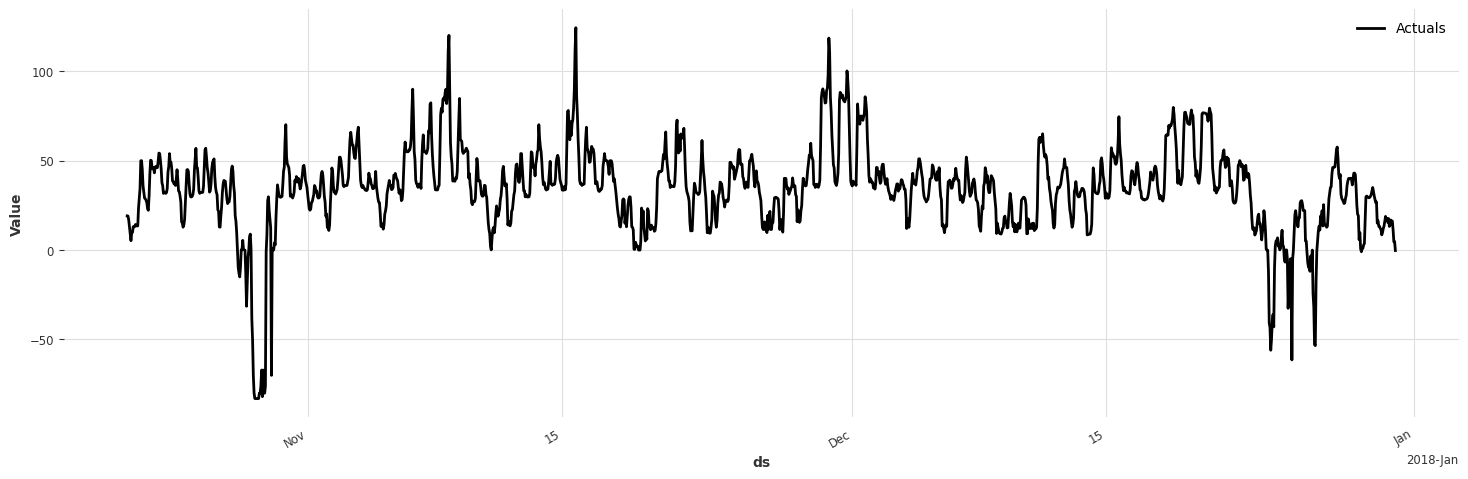

In [ ]:
plt.figure(figsize=(18, 6))
y_series.plot(label='Actuals')
plt.xlabel('Time')
plt.ylabel('Value')
rmse_cv = []
for i in range(len(cv)):
    his_pred = TimeSeries.pd_series(scaler_for_y.inverse_transform(cv[i]))
    his_pred.plot(label='History Predictions')
    start = his_pred.index.min()
    end = his_pred.index.max()
    actuals = df['y'][start:end]
    # error_cv = np.sqrt(mean_squared_error(actuals, his_pred))
    # rmse_cv.append(error_cv)

print(cv[i])
print(f"The CV error is {np.mean(rmse_cv)}")

plt.show()